# 06.1b: Singularity Neighborhood

**Goal:** Explore tokens near (but not in) the degenerate singularity.

The 814 degenerate tokens are at distance 0 from each other. But the vertical line in the sky map persists even with masking, suggesting there's a broader **near-degenerate cluster** around the singularity.

We'll:
1. Start from a reference token in the singularity
2. Find nearest neighbors at various distance shells
3. Decode and categorize tokens at each shell
4. Map the radial structure of the overdensity

This reveals whether the singularity is:
- An isolated pathology (sharp boundary)
- Core of a larger dense cluster (gradual density gradient)

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Reference token (member of degenerate cluster)
REFERENCE_TOKEN_ID = 124033  # Thai 'ไม่' (not)

# Distance shells to explore (gamma units)
# We'll find tokens at distances: 0-shell1, shell1-shell2, shell2-shell3, etc.
SHELLS = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

# How many tokens to show per shell
TOKENS_PER_SHELL = 20

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from collections import Counter
import unicodedata

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
# Load γ' (centered embeddings)
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

N, d = gamma_prime.shape

print(f"Loaded γ' (centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load tokenizer
print(f"Loading tokenizer: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer loaded.")

Loaded γ' (centered):
  Tokens: 151,936
  Dimensions: 2,560

Loading tokenizer: Qwen/Qwen3-4B-Instruct-2507...


Tokenizer loaded.


## Step 2: Compute Distances from Reference

In [4]:
print(f"\nComputing distances from reference token {REFERENCE_TOKEN_ID}...\n")

# Decode reference
ref_str = tokenizer.decode([REFERENCE_TOKEN_ID])
print(f"Reference token: {repr(ref_str)}")
print()

# Get reference embedding
reference = gamma_prime[REFERENCE_TOKEN_ID]

# Compute Euclidean distances to all tokens
distances = torch.norm(gamma_prime - reference, dim=1)

print(f"Distance statistics:")
print(f"  Min: {distances.min().item():.12f}")
print(f"  Max: {distances.max().item():.12f}")
print(f"  Mean: {distances.mean().item():.12f}")
print(f"  Median: {distances.median().item():.12f}")


Computing distances from reference token 124033...

Reference token: 'ไม่'

Distance statistics:
  Min: 0.000000000000
  Max: 1.571872115135
  Mean: 1.050221085548
  Median: 1.088246703148


## Step 3: Bin Tokens by Distance Shell

In [5]:
print("\n" + "="*60)
print("DISTANCE SHELLS")
print("="*60)
print()

# Add 0 and infinity to shell boundaries
shell_edges = [0] + SHELLS + [float('inf')]

# Bin tokens by distance
shell_data = []

for i in range(len(shell_edges) - 1):
    lower = shell_edges[i]
    upper = shell_edges[i + 1]
    
    # Find tokens in this shell
    in_shell = (distances > lower) & (distances <= upper)
    n_in_shell = in_shell.sum().item()
    
    if upper == float('inf'):
        shell_label = f"> {lower:.6f}"
    else:
        shell_label = f"{lower:.6f} - {upper:.6f}"
    
    print(f"Shell {i}: {shell_label} gamma units")
    print(f"  Count: {n_in_shell:,} tokens ({n_in_shell/N*100:.4f}%)")
    
    if n_in_shell > 0:
        shell_dists = distances[in_shell]
        print(f"  Distance range: [{shell_dists.min().item():.12f}, {shell_dists.max().item():.12f}]")
    print()
    
    shell_data.append({
        'shell_idx': i,
        'lower': lower,
        'upper': upper,
        'mask': in_shell,
        'count': n_in_shell
    })


DISTANCE SHELLS

Shell 0: 0.000000 - 0.000001 gamma units
  Count: 20 tokens (0.0132%)
  Distance range: [0.000000007451, 0.000000903888]

Shell 1: 0.000001 - 0.000010 gamma units
  Count: 8 tokens (0.0053%)
  Distance range: [0.000001379565, 0.000006095504]

Shell 2: 0.000010 - 0.000100 gamma units
  Count: 1,341 tokens (0.8826%)
  Distance range: [0.000015258789, 0.000099800476]

Shell 3: 0.000100 - 0.001000 gamma units
  Count: 27 tokens (0.0178%)
  Distance range: [0.000103259888, 0.000995554030]

Shell 4: 0.001000 - 0.010000 gamma units
  Count: 11 tokens (0.0072%)
  Distance range: [0.001017709495, 0.009574949741]

Shell 5: 0.010000 - 0.100000 gamma units
  Count: 365 tokens (0.2402%)
  Distance range: [0.014709340408, 0.099900037050]

Shell 6: > 0.100000 gamma units
  Count: 149,350 tokens (98.2980%)
  Distance range: [0.100244529545, 1.571872115135]



## Step 4: Sample Tokens from Each Shell

In [6]:
def categorize_token(token_str):
    """Categorize token by script/type."""
    if not token_str:
        return 'Empty'
    
    c = token_str[0]
    
    try:
        cat = unicodedata.category(c)
        if cat in ['Cc', 'Cf', 'Cn', 'Co', 'Cs']:
            return 'Unprintable'
        
        name = unicodedata.name(c, '')
        if 'THAI' in name:
            return 'Thai'
        elif 'HEBREW' in name:
            return 'Hebrew'
        elif 'ARABIC' in name:
            return 'Arabic'
        elif 'CJK' in name or 'IDEOGRAPH' in name:
            return 'CJK'
        elif 'LATIN' in name:
            return 'Latin'
        elif 'CYRILLIC' in name:
            return 'Cyrillic'
        else:
            return 'Other'
    except:
        return 'Unknown'

print("\n" + "="*60)
print("TOKENS IN EACH SHELL")
print("="*60)

for shell in shell_data:
    if shell['count'] == 0:
        continue
    
    print(f"\n{'='*60}")
    if shell['upper'] == float('inf'):
        print(f"SHELL {shell['shell_idx']}: > {shell['lower']:.6f} gamma units")
    else:
        print(f"SHELL {shell['shell_idx']}: {shell['lower']:.6f} - {shell['upper']:.6f} gamma units")
    print(f"{shell['count']:,} tokens")
    print(f"{'='*60}\n")
    
    # Get indices
    indices_in_shell = torch.where(shell['mask'])[0]
    shell_distances = distances[indices_in_shell]
    
    # Sort by distance
    sorted_indices = torch.argsort(shell_distances)
    
    # Sample: take first N (closest to shell boundary)
    n_to_show = min(TOKENS_PER_SHELL, len(indices_in_shell))
    
    results = []
    categories = []
    
    for rank, idx in enumerate(sorted_indices[:n_to_show], 1):
        token_id = indices_in_shell[idx].item()
        distance = shell_distances[idx].item()
        token_str = tokenizer.decode([token_id])
        cat = categorize_token(token_str)
        categories.append(cat)
        
        results.append({
            'Rank': rank,
            'Token_ID': token_id,
            'Distance': f"{distance:.12f}",
            'Category': cat,
            'Token': repr(token_str)
        })
    
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    
    # Categorize ALL tokens in shell
    all_categories = []
    for token_id in indices_in_shell:
        token_str = tokenizer.decode([token_id.item()])
        cat = categorize_token(token_str)
        all_categories.append(cat)
    
    category_counts = Counter(all_categories)
    
    print(f"\nCategory distribution (all {shell['count']:,} tokens):")
    for cat, count in category_counts.most_common():
        pct = count / shell['count'] * 100
        print(f"  {cat:15s}: {count:6d} ({pct:5.1f}%)")


TOKENS IN EACH SHELL

SHELL 0: 0.000000 - 0.000001 gamma units
20 tokens



 Rank  Token_ID       Distance Category       Token
    1    130799 0.000000007451     Thai    'ไม่ใช่'
    2    135619 0.000000007451     Thai     'เปอร์'
    3    138490 0.000000007451     Thai   'ร่วมกัน'
    4    140815 0.000000007451     Thai    'ที่น่า'
    5    143457 0.000000007451    Other     ' của'
    6    124084 0.000000010537     Thai       'รับ'
    7    126775 0.000000010537     Thai       'รัฐ'
    8    140303 0.000000010537     Thai       'ซ้ำ'
    9    147056 0.000000010537      CJK         '切'
   10    129621 0.000000014901     Thai    'ของคุณ'
   11    139316 0.000000016660     Thai     'ขอให้'
   12    146175 0.000000016660      CJK         '利'
   13    136965 0.000000022352     Thai    'ไปแล้ว'
   14    126848 0.000000030720     Thai       'เดิ'
   15    128477 0.000000033320    Other      ' ที่'
   16    139432 0.000000060069     Thai   'เห็นว่า'
   17    124530 0.000000093356     Thai        'ค่'
   18    129978 0.000000685777     Thai     'เขียน'
   19    138


Category distribution (all 1,341 tokens):
  Thai           :    788 ( 58.8%)
  Empty          :    266 ( 19.8%)
  CJK            :    151 ( 11.3%)
  Other          :     91 (  6.8%)
  Arabic         :     27 (  2.0%)
  Hebrew         :     12 (  0.9%)
  Latin          :      6 (  0.4%)

SHELL 3: 0.000100 - 0.001000 gamma units
27 tokens

 Rank  Token_ID       Distance Category          Token
    1    143480 0.000103259888     Thai       'อธิบาย'
    2    123952 0.000126608298     Thai           'ด้'
    3    125687 0.000127000123     Thai          'อัน'
    4    125047 0.000131747205     Thai           'ปี'
    5    136834 0.000134393442     Thai    'เรื่องนี้'
    6    148826 0.000139438373      CJK            '視'
    7    143546 0.000139859432     Thai        'ขนส่ง'
    8    132191 0.000142684847     Thai       'ติดตาม'
    9    149121 0.000144258462      CJK            '漏'
   10    129604 0.000146208040     Thai           'พู'
   11    125125 0.000147882631     Thai           'สุ'


Category distribution (all 149,350 tokens):
  Other          :  85212 ( 57.1%)
  Latin          :  29733 ( 19.9%)
  CJK            :  25632 ( 17.2%)
  Arabic         :   2585 (  1.7%)
  Cyrillic       :   1925 (  1.3%)
  Hebrew         :   1882 (  1.3%)
  Unprintable    :   1427 (  1.0%)
  Thai           :    954 (  0.6%)


## Step 5: Visualize Radial Density


RADIAL DENSITY PROFILE



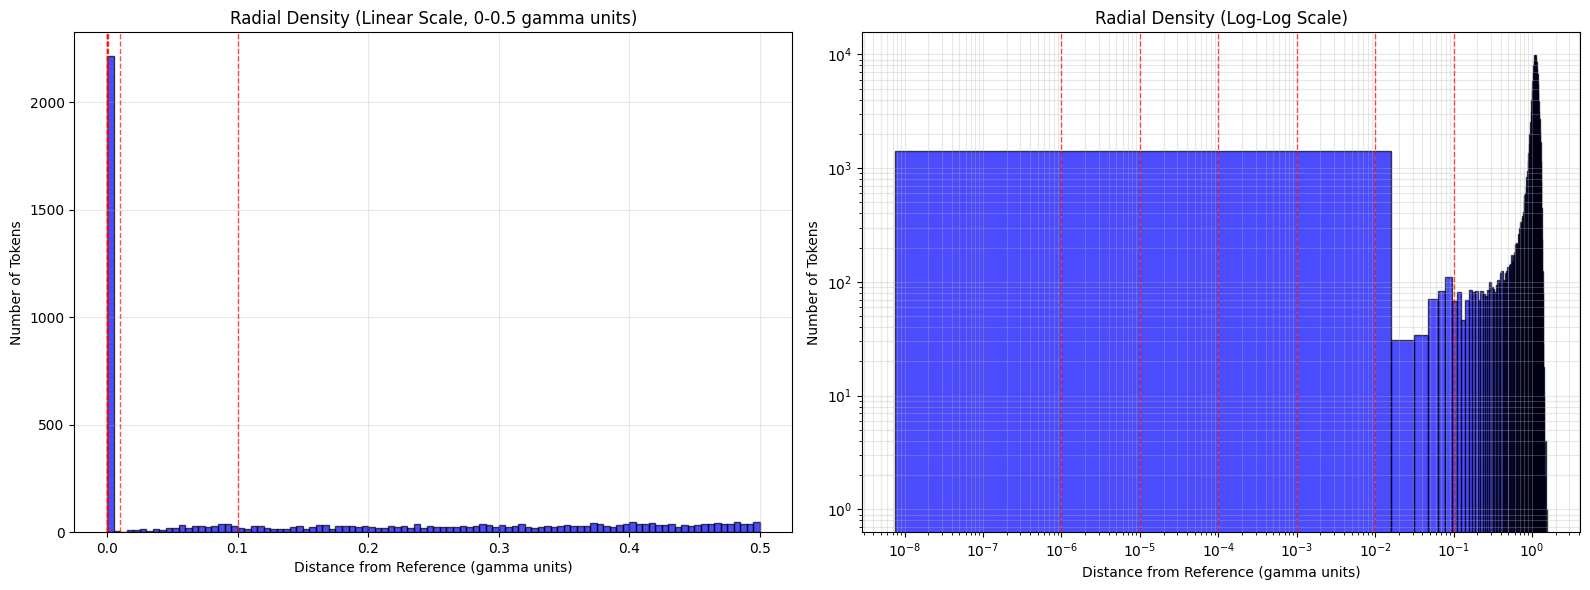


Histograms show token density vs distance from reference.
Sharp peaks indicate dense shells; gradual decay indicates smooth distribution.


In [7]:
print("\n" + "="*60)
print("RADIAL DENSITY PROFILE")
print("="*60)
print()

# Create histogram of distances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)

# Linear scale (focus on near region)
ax1.hist(distances.cpu().numpy(), bins=100, range=(0, 0.5), color='blue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Distance from Reference (gamma units)')
ax1.set_ylabel('Number of Tokens')
ax1.set_title('Radial Density (Linear Scale, 0-0.5 gamma units)')
ax1.grid(True, alpha=0.3)

# Add shell boundaries
for shell_edge in SHELLS:
    if shell_edge <= 0.5:
        ax1.axvline(shell_edge, color='red', linestyle='--', linewidth=1, alpha=0.7)

# Log scale (full range)
# Filter out zeros for log plot
distances_nonzero = distances[distances > 0].cpu().numpy()
ax2.hist(distances_nonzero, bins=100, color='blue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Distance from Reference (gamma units)')
ax2.set_ylabel('Number of Tokens')
ax2.set_title('Radial Density (Log-Log Scale)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

# Add shell boundaries
for shell_edge in SHELLS:
    ax2.axvline(shell_edge, color='red', linestyle='--', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.show()

print("\nHistograms show token density vs distance from reference.")
print("Sharp peaks indicate dense shells; gradual decay indicates smooth distribution.")

## Summary

Explored the neighborhood around the degenerate singularity.

**Key questions:**
- Is the singularity isolated (sharp boundary) or core of larger cluster (gradual gradient)?
- What tokens live in the near-degenerate shells?
- Does the Thai dominance extend beyond the singularity?

The radial density profile reveals whether training created:
- **Sharp singularity**: Sudden drop in density after the degenerate cluster
- **Dense cluster**: Gradual decrease in density, suggesting broader pathology
- **Exclusion zone**: Gap in density (the black stripe on sky map)